In [10]:
import backtrader as bt
import pandas as pd
import duckdb

etfs = ['561300', '159726', '515100', '513500',
        '518880', '164824', '159985', '513330', '513100',
        '513030', '513520']
start_date = '2023-01-18'
end_date   = '2025-08-25'

con = duckdb.connect(database=':memory:', read_only=False) 
symbols_tuple = tuple(etfs)

path = '../dataset/data/etf_prices/**/**.parquet'

query = f"""
SELECT
    date,
    open,
    high,
    low,
    close,
    volume,
    turnover,
    symbol
FROM read_parquet('{path}')
WHERE symbol IN {symbols_tuple}
AND date BETWEEN '{start_date}' AND '{end_date}'
ORDER BY symbol, date
"""

df_origin = con.execute(query).df()
con.close()

# 类型转换
df_origin['date'] = pd.to_datetime(df_origin['date'])
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
df_origin[numeric_cols] = df_origin[numeric_cols].astype(float)
df_origin.tail(10)

,date,open,high,low,close,volume,turnover,symbol
6919,2025-08-12,0.883,0.890,0.882,0.888,358191.0,31773432.0,561300
6920,2025-08-13,0.888,0.900,0.888,0.897,266841.0,23871007.0,561300
6921,2025-08-14,0.898,0.906,0.895,0.896,453259.0,40863159.0,561300
6922,2025-08-15,0.895,0.905,0.894,0.902,877880.0,79046221.0,561300
6923,2025-08-18,0.904,0.915,0.902,0.909,594706.0,54086799.0,561300
6924,2025-08-19,0.906,0.912,0.901,0.901,283485.0,25664396.0,561300
6925,2025-08-20,0.901,0.917,0.896,0.915,1202490.0,108643735.0,561300
6926,2025-08-21,0.917,0.923,0.915,0.919,638512.0,58637918.0,561300
6927,2025-08-22,0.922,0.938,0.918,0.937,2016412.0,188191438.0,561300
6928,2025-08-25,0.939,0.956,0.939,0.956,716315.0,67922685.0,561300


In [32]:
df_all = df_origin[df_origin.date >= '2025-05-26']
df_all

,date,open,high,low,close,volume,turnover,symbol
565,2025-05-26,1.162,1.175,1.162,1.165,70525.0,8241321.4,159726
566,2025-05-27,1.164,1.174,1.164,1.170,60411.0,7066293.5,159726
567,2025-05-28,1.170,1.180,1.170,1.177,91970.0,10822589.6,159726
568,2025-05-29,1.185,1.188,1.177,1.185,74746.0,8842711.3,159726
569,2025-05-30,1.183,1.185,1.177,1.181,42309.0,4995707.9,159726
...,...,...,...,...,...,...,...,...
6924,2025-08-19,0.906,0.912,0.901,0.901,283485.0,25664396.0,561300
6925,2025-08-20,0.901,0.917,0.896,0.915,1202490.0,108643735.0,561300
6926,2025-08-21,0.917,0.923,0.915,0.919,638512.0,58637918.0,561300
6927,2025-08-22,0.922,0.938,0.918,0.937,2016412.0,188191438.0,561300


In [36]:
from sklearn.linear_model import LinearRegression
import numpy as np

def calculate_score(data: np.ndarray) -> float:
    """计算强弱得分"""
    x = np.arange(1, len(data) + 1).reshape(-1, 1)
    y = data / data[0]   # 归一化
    reg = LinearRegression().fit(x, y)
    slope = reg.coef_[0]
    r2 = reg.score(x, y)
    return slope * r2


class MomentumTopN(bt.Strategy):
    params = (
        ('lookback_period', 20),   # 回归窗口（替代 momentum_period）
        ('ma_period', 60),        # 均线周期
        ('topn', 3),               # 每期最大持仓数
        ('rebalance_days', 5),     # 调仓间隔
        ('max_drawdown', 0.1),      # 最大回撤阈值
    )

    def __init__(self):
        self.inds = {}
        for d in self.datas:
            self.inds[d] = dict(
                ma=bt.indicators.SimpleMovingAverage(d.close,
                                                     period=self.p.ma_period)
            )
        self.counter = 0
        self.max_equity = 0

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price:.2f}, Size: {order.executed.size}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {order.executed.price:.2f}, Size: {order.executed.size}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')

    def next(self):
        self.counter += 1
        if self.counter % self.p.rebalance_days != 0:
            return  # 只在调仓日操作

        current_equity = self.broker.getvalue()
        self.max_equity = max(self.max_equity, current_equity) if self.max_equity else current_equity
        drawdown = (self.max_equity - current_equity) / self.max_equity
        risk_factor = 0.5 + 0.5 * (1 - min(drawdown / self.p.max_drawdown, 1.0))

        eligible = []
        scores = {}

        for d in self.datas:
            if len(d) >= max(self.p.lookback_period, self.p.ma_period):
                if d.close[0] > self.inds[d]['ma'][0]:
                    # 取回归窗口的数据
                    close_array = np.array(d.get(size=self.p.lookback_period))
                    score = calculate_score(close_array)
                    scores[d] = score
                    eligible.append(d)

        # 按 score 排序
        eligible.sort(key=lambda d: scores[d], reverse=True)

        # TopN
        top = eligible[:self.p.topn]
        weight = 1.0 * risk_factor / len(top) if top else 0.0

        # 调仓
        for d in self.datas:
            pos = self.getposition(d).size
            if d in top:
                target_size = int((weight * self.broker.getvalue()) / d.close[0])
                if pos != target_size:
                    self.order_target_size(d, target_size)
            else:
                if pos:
                    self.order_target_size(d, 0)


In [37]:
# ------------------------------------------------------------------
# 2. 构造 cerebro 并循环添加每个 ETF 的数据
# ------------------------------------------------------------------
cerebro = bt.Cerebro()

for symbol in etfs:
    # 取出当前标的
    df_sym = df_all[df_all['symbol'] == symbol].copy()

    # 确保按日期排序
    df_sym.sort_values('date', inplace=True)

    # 设置 datetime 为索引
    df_sym.set_index('date', inplace=True)

    # 删除多余的 symbol 列
    df_sym.drop(columns=['symbol'], inplace=True)

    # 缺失值前向填充（如有停牌）
    df_sym = df_sym.ffill()

    # 构建 backtrader 数据源
    data = bt.feeds.PandasData(
        dataname=df_sym,
        name=symbol,
        # 如果列名与默认一致，无需额外映射
    )
    cerebro.adddata(data)

## 回测参数
cerebro.addstrategy(MomentumTopN)
cerebro.broker.setcommission(commission=0.0005)
cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.broker.setcash(100000) 

# ------------------------------------------------------------------
# 4. 运行回测
# ------------------------------------------------------------------
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

2025-08-25, BUY EXECUTED, Price: 0.94, Size: 35574, Cost: 33403.99, Comm: 16.70
2025-08-25, BUY EXECUTED, Price: 1.99, Size: 16835, Cost: 33535.32, Comm: 16.77


期望最终资金: 1.01x
亏损概率: 0.00%
95% 置信区间: [1.00, 1.02]


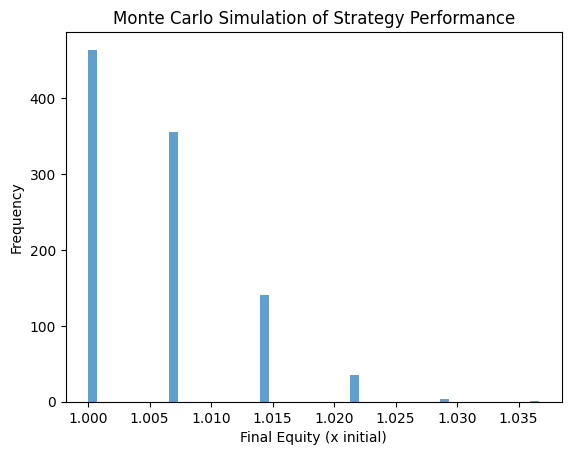

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 蒙特卡洛重采样
num_simulations = 1000
num_trades = 50
final_equity = []

for _ in range(num_simulations):
    sim_returns = np.random.choice(returns, size=num_trades, replace=True)
    equity_curve = (1 + sim_returns).cumprod()
    final_equity.append(equity_curve[-1])

final_equity = np.array(final_equity)

# 结果分析
print(f"期望最终资金: {final_equity.mean():.2f}x")
print(f"亏损概率: {np.mean(final_equity < 1):.2%}")
print(f"95% 置信区间: [{np.percentile(final_equity, 2.5):.2f}, {np.percentile(final_equity, 97.5):.2f}]")

# 可视化
plt.hist(final_equity, bins=50, alpha=0.7)
plt.title("Monte Carlo Simulation of Strategy Performance")
plt.xlabel("Final Equity (x initial)")
plt.ylabel("Frequency")
plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-01-18
End Period                 2025-08-18
Risk-Free Rate             0.0%
Time in Market             86.0%

Cumulative Return          38.57%
CAGR﹪                     14.06%

Sharpe                     1.15
Prob. Sharpe Ratio         96.03%
Smart Sharpe               1.07
Sortino                    1.62
Smart Sortino              1.52
Sortino/√2                 1.15
Smart Sortino/√2           1.07
Omega                      1.26

Max Drawdown               -9.83%
Max DD Date                2025-01-13
Max DD Period Start        2024-07-10
Max DD Period End          2025-03-17
Longest DD Days            251
Volatility (ann.)          12.1%
Calmar                     1.43
Skew                       -0.72
Kurtosis                   7.38

Expected Daily %           0.05%
Expected Monthly %         1.02%
Expected Yearly %          11.49%
Kelly Criterion            11.08%
Risk of Ruin 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-07-10,2025-01-13,2025-03-17,251,-9.826613,-9.095652
2,2023-09-18,2023-10-23,2023-12-25,99,-6.997665,-6.716191
3,2025-03-20,2025-04-07,2025-05-08,50,-6.735096,-5.347140
4,2024-01-24,2024-01-26,2024-02-22,30,-6.350308,-5.844442
5,2024-04-15,2024-04-23,2024-05-16,32,-4.667768,-4.276776


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


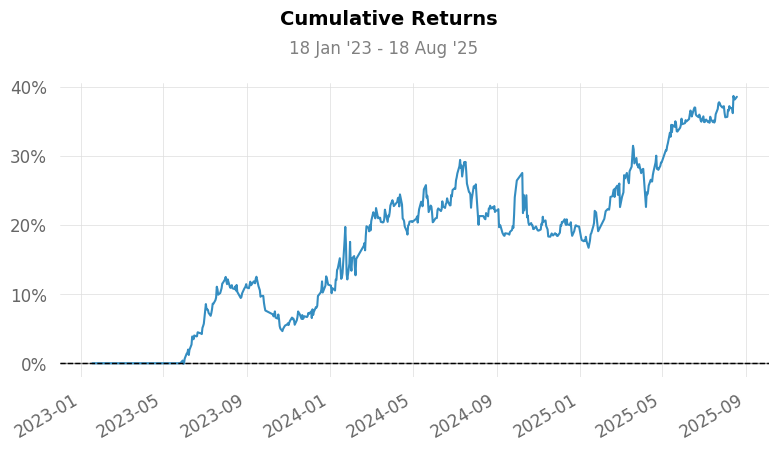

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


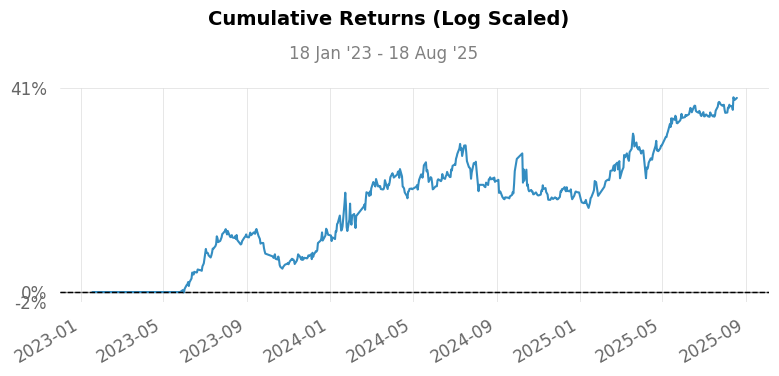

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


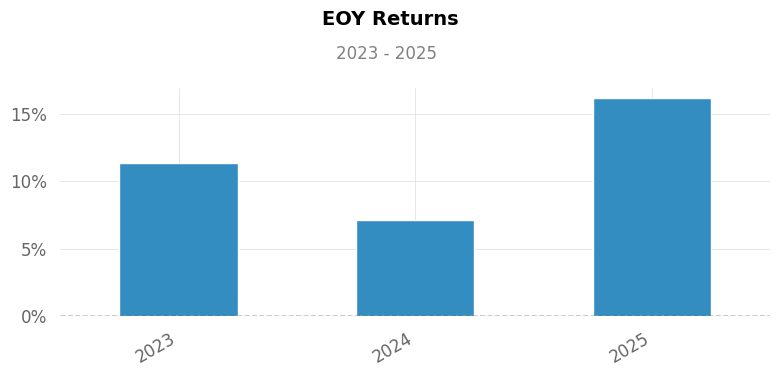

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


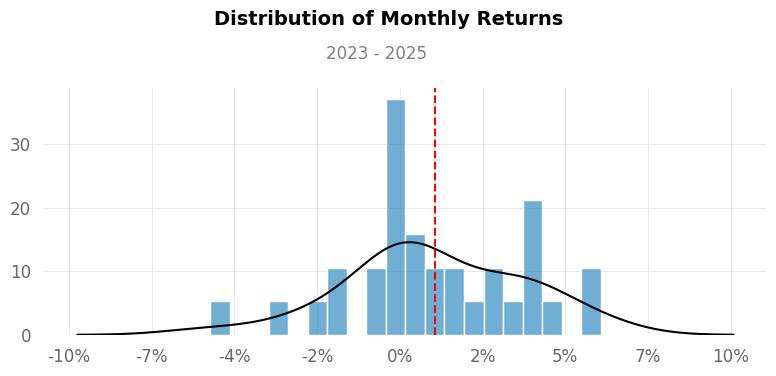

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


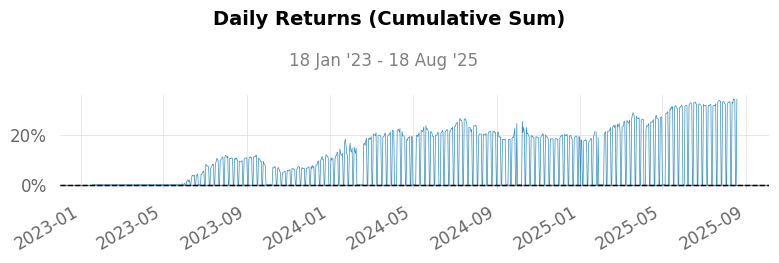

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


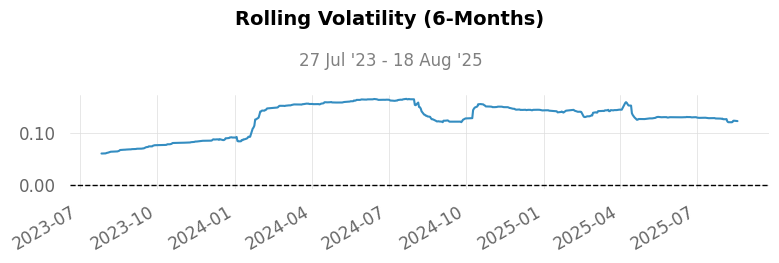

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


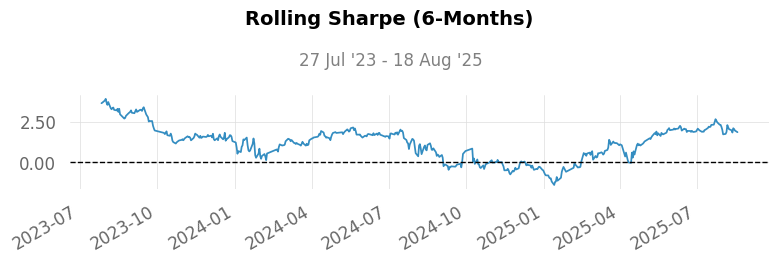

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


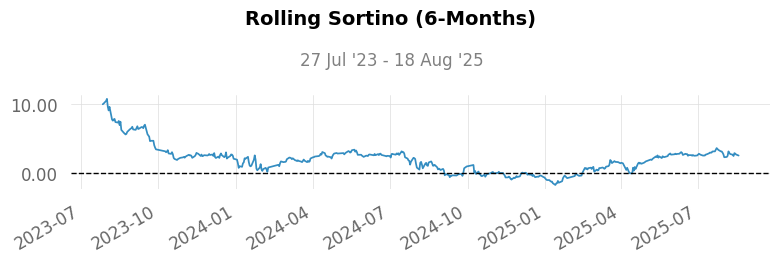

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


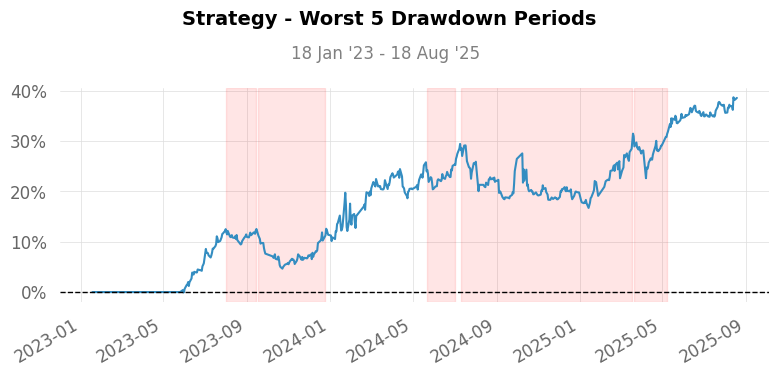

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


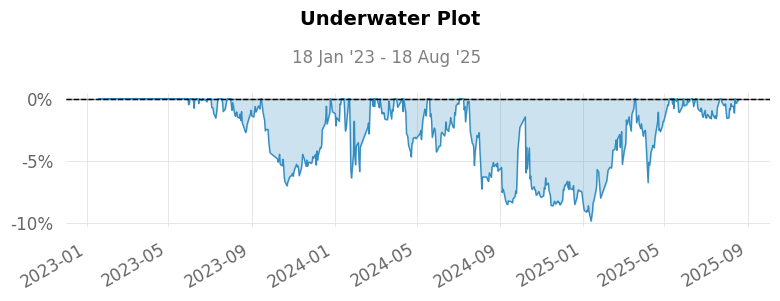

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


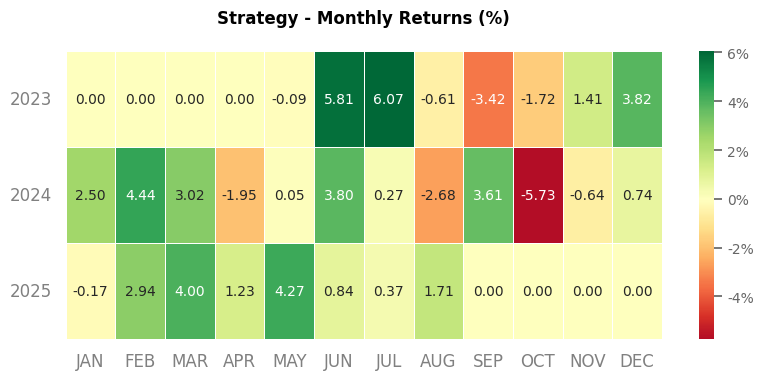

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


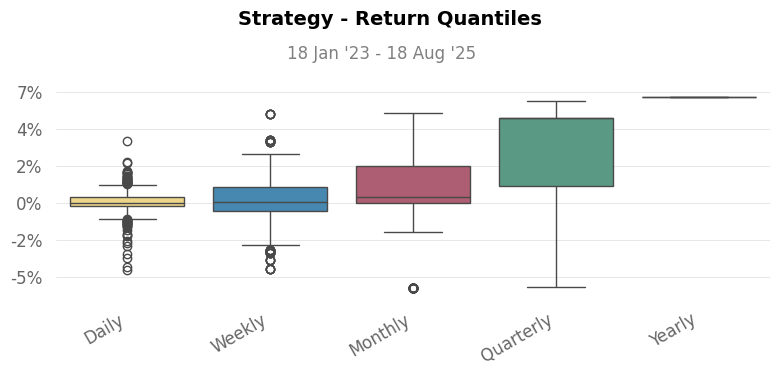

In [130]:
import quantstats as qs

qs.reports.full(returns)

In [15]:
positions

,513520,cash
Datetime,,
2024-08-15 00:00:00+00:00,0.0,100000.000000
2024-08-16 00:00:00+00:00,0.0,100000.000000
2024-08-19 00:00:00+00:00,0.0,100000.000000
2024-08-20 00:00:00+00:00,0.0,100000.000000
2024-08-21 00:00:00+00:00,0.0,100000.000000
...,...,...
2025-08-12 00:00:00+00:00,0.0,33047.933249
2025-08-13 00:00:00+00:00,0.0,33047.933249
2025-08-14 00:00:00+00:00,0.0,33047.933249


In [11]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2022-12-30 00:00:00+00:00,841,3.970,5,518880,-3338.770
2022-12-30 00:00:00+00:00,1678,1.987,7,159985,-3334.186
2023-01-09 00:00:00+00:00,3944,0.842,1,159726,-3320.848
2023-01-09 00:00:00+00:00,-9,4.016,5,518880,36.144
2023-01-09 00:00:00+00:00,-1678,1.955,7,159985,3280.490
...,...,...,...,...,...
2025-07-11 00:00:00+00:00,-1,4.248,3,513500,4.248
2025-07-11 00:00:00+00:00,501,8.170,9,513100,-4093.170
2025-07-18 00:00:00+00:00,-969,4.282,3,513500,4149.258
